In [3]:
# Stable Diffusion 설치
%pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), Posix

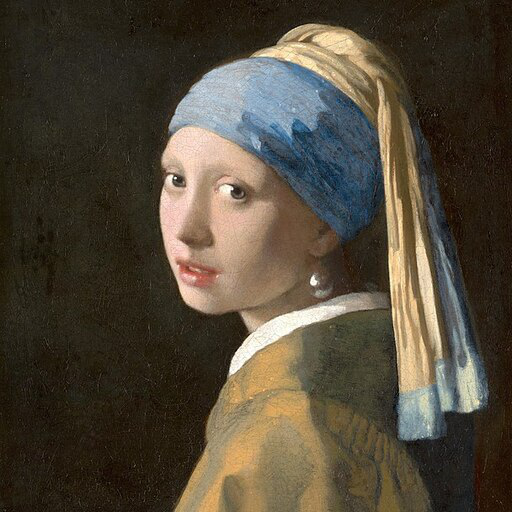

In [4]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

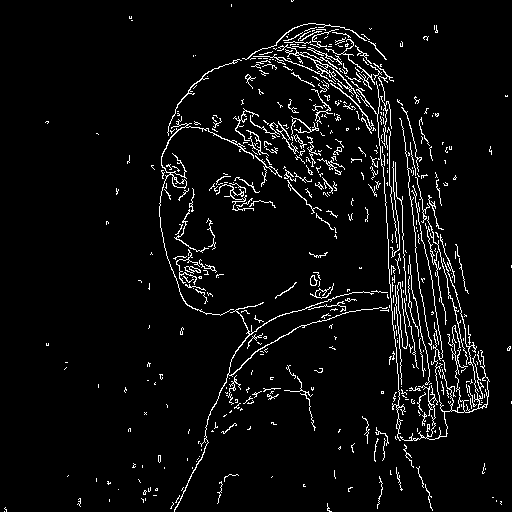

In [5]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [6]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

# torch_dtype을 float32로 변경
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float32)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float32
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

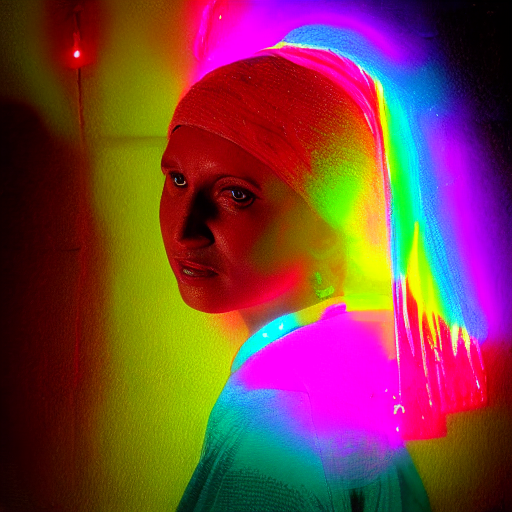

In [7]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

In [8]:
# 프롬프트, negative prompts 및 하이퍼파라미터 조합을 사용하여 이미지 생성
# 프롬프트 리스트

prompts = [
    "disco dancer with colorful lights",
    "a serene landscape with a setting sun",
    "a futuristic city skyline at night"
]

# 원치 않는 요소 (negative prompts)
negative_prompts = [
    "",
    "no animals",
    "no buildings"
]

# 하이퍼파라미터 설정
hyperparameters = {
    'num_inference_steps': [20, 50, 100],
    'guidance_scale': [1.0, 5.0, 7.5],
    'controlnet_conditioning_scale': [0.5, 1.0, 1.5],
    'negative_prompt': negative_prompts
}

image_count = 0
max_images = 10

for prompt in prompts:
    if image_count >= max_images:
        break
    for num_steps in hyperparameters['num_inference_steps']:
        if image_count >= max_images:
            break
        for guidance in hyperparameters['guidance_scale']:
            if image_count >= max_images:
                break
            for conditioning_scale in hyperparameters['controlnet_conditioning_scale']:
                if image_count >= max_images:
                    break
                for neg_prompt in hyperparameters['negative_prompt']:
                    if image_count >= max_images:
                        break
                    
                    print(f"Generating image for prompt: '{prompt}' with {num_steps} steps, guidance scale {guidance}, conditioning scale {conditioning_scale}, and negative prompt '{neg_prompt}'")
            
                    generated_image = canny_pipe(
                        prompt=prompt,
                        negative_prompt=neg_prompt,
                        num_inference_steps=num_steps,
                        guidance_scale=guidance,
                        controlnet_conditioning_scale=conditioning_scale,
                        generator=generator,
                        image=canny_image
                    ).images[0]
            
                    # 생성된 이미지 저장
                    filename = f"/aiffel/aiffel/generated_{prompt.replace(' ', '_')}_{num_steps}steps_{guidance}guidance_{conditioning_scale}conditioning_{neg_prompt.replace(' ', '_')}.png"
                    generated_image.save(filename)
                    
                    image_count += 1


Generating image for prompt: 'disco dancer with colorful lights' with 20 steps, guidance scale 1.0, conditioning scale 0.5, and negative prompt ''


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image for prompt: 'disco dancer with colorful lights' with 20 steps, guidance scale 1.0, conditioning scale 0.5, and negative prompt 'no animals'


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image for prompt: 'disco dancer with colorful lights' with 20 steps, guidance scale 1.0, conditioning scale 0.5, and negative prompt 'no buildings'


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image for prompt: 'disco dancer with colorful lights' with 20 steps, guidance scale 1.0, conditioning scale 1.0, and negative prompt ''


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating image for prompt: 'disco dancer with colorful lights' with 20 steps, guidance scale 1.0, conditioning scale 1.0, and negative prompt 'no animals'


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image for prompt: 'disco dancer with colorful lights' with 20 steps, guidance scale 1.0, conditioning scale 1.0, and negative prompt 'no buildings'


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image for prompt: 'disco dancer with colorful lights' with 20 steps, guidance scale 1.0, conditioning scale 1.5, and negative prompt ''


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating image for prompt: 'disco dancer with colorful lights' with 20 steps, guidance scale 1.0, conditioning scale 1.5, and negative prompt 'no animals'


  0%|          | 0/20 [00:00<?, ?it/s]

Generating image for prompt: 'disco dancer with colorful lights' with 20 steps, guidance scale 1.0, conditioning scale 1.5, and negative prompt 'no buildings'


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating image for prompt: 'disco dancer with colorful lights' with 20 steps, guidance scale 5.0, conditioning scale 0.5, and negative prompt ''


  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
# 인체 자세감지
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
%pip install controlnet-aux==0.0.1

     |████████████████████████████████| 42 kB 1.4 MB/s             
Note: you may need to restart the kernel to use updated packages.


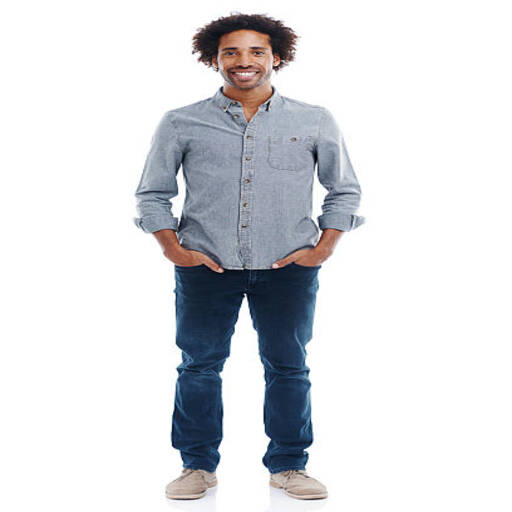

In [10]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


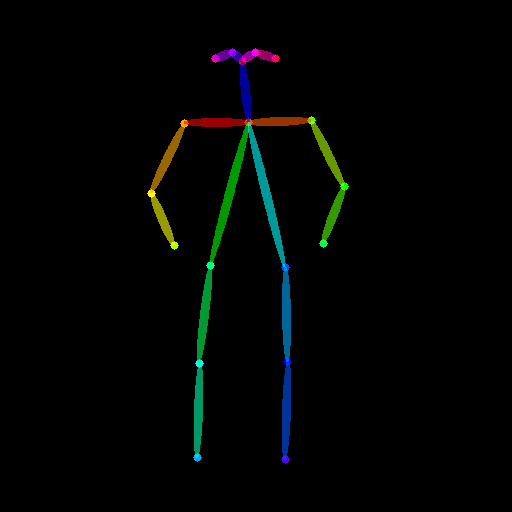

In [11]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

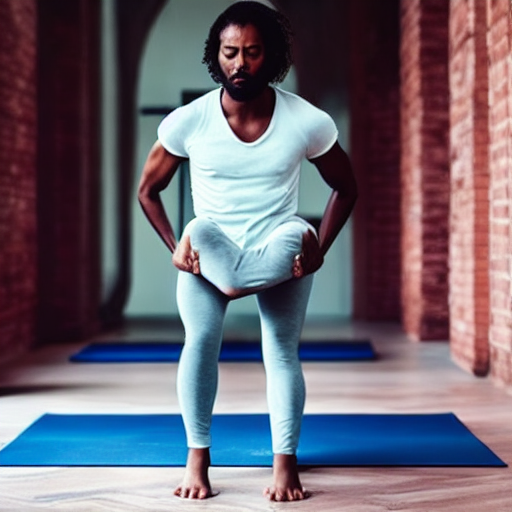

In [13]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)

# 프롬프트를 작성합니다. 
prompt = "person doing yoga"
negative_prompt = "no background"

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20, # 추론 횟수를 조절하여 이미지의 해상도 및 생성 시간을 조절할 수 있습니다.
    guidance_scale=7.5,     # 주어진 프롬프트에 얼마나 근접하게 이미지를 생성할지 결정하는 값입니다.
    generator=generator, 
    image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1

In [14]:
# 윤곽선 + 인체 자세 감지
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# 이미지를 불러오세요. 
canny_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = Image.fromarray(canny_image)

In [15]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# 이미지를 불러옵니다. 
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

cuda


In [16]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnets = [ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16), 
               ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnets=controlnets, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt = "person dancing"
negative_prompt = "no background"

# seed를 지정합니다. 
generator = torch.manual_seed(0)

images = [openpose_image, canny_image]

# 이미지를 생성합니다. 
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    generator=generator,
    image=images
).images[0]

# 생성된 이미지를 저장합니다.
image.save("aiffel/aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image

Keyword arguments {'controlnets': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2,

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


ValueError: Pipeline <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> expected {'unet', 'feature_extractor', 'scheduler', 'text_encoder', 'safety_checker', 'vae', 'tokenizer', 'controlnet'}, but only {'unet', 'feature_extractor', 'scheduler', 'text_encoder', 'safety_checker', 'vae', 'tokenizer'} were passed.

In [17]:
print("생성한 이미지를 올린 곳은 aiffel/aiffel/multi_controlnet_output.png 입니다.")

생성한 이미지를 올린 곳은 aiffel/aiffel/multi_controlnet_output.png 입니다.
